In [1]:
import controllers
import controlpy
import dynamics_models
import numpy as np
import matplotlib.pyplot as plt

## Dubin Car
do not use ode45-style numerical integration to check correctness of linearizations

In [2]:
n = 4
init_state = np.zeros(n)
dt = 0.1
process_noise = np.zeros((n,n))

accel_limits = (-1,1)
delta_limits = (- np.pi / 6,  np.pi / 6)
v_ref = 4
y_ref = lambda t: 1 if t > 10 and t < 30 else 0

vehicle = dynamics_models.DubinCar(init_state, dt, process_noise, use_ode_integrator=False)

speed_controller = controllers.PID(1, 0.00, 0, v_ref, 0, dt, accel_limits)
steering_controller = controllers.PID(.2, 0.01, 1, y_ref(vehicle.t), 0, dt, delta_limits)
speed_controller.build()
steering_controller.build()

In [3]:
x = vehicle.x
x_traj = [x]
u_traj = []

for _ in range(int(60/dt)):
    steering_controller.set_reference(y_ref(vehicle.t), 0)
    a = speed_controller.solve(x[3])
    delta = steering_controller.solve(x[1])
    u = np.array([a, delta])
    x = vehicle.f(u)
    x_traj.append(x)
    u_traj.append(u)

In [4]:
linearizations = [vehicle.get_linearization(x, u, dt) for x, u in zip(x_traj, u_traj)]

In [5]:
errors = []
x_preds = []
for i, (A,B,C) in enumerate(linearizations):
    x_pred = A @ x_traj[i] + B @ u_traj[i] + C
    error = np.abs(x_pred - x_traj[i + 1])
    errors.append(error)
    x_preds.append(x_pred)
errors = np.array(errors).T

In [6]:
np.max(errors) < 1e-20

True

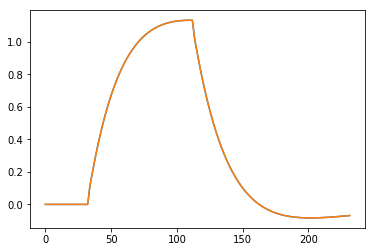

In [7]:
x_traj = np.array(x_traj)
u_traj = np.array(u_traj)
x_preds = np.array(x_preds)
plt.plot(x_traj[:,0], x_traj[:,1])
plt.plot(x_preds[:,0], x_preds[:,1])

## 2-D Drone

In [15]:
n = 6
dt = 0.1
m = 0.5
l = 0.4
I = (1 / 3) * m * (l**2)
init_state = np.zeros(6)
process_noise = np.zeros((6,6))
u_limits = (0, 10)
pos_limit = (-1,1)
period = 20
x_ref = lambda t: np.sin(2 * np.pi / period * t)
y_ref = lambda t: np.cos(2 * np.pi / period * t)
offset = m * dynamics_models.GRAVITY
ref = lambda t: np.array([x_ref(t), y_ref(t), 0, 0, 0, 0])
vehicle = dynamics_models.PlanarQuadrotor(init_state, m, l , I, dt, process_noise, use_ode_integrator=True)
A, B, C = vehicle.get_linearization(init_state, np.array([offset, offset]) / 2, dt)
K, _, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, np.diag([10,10,1,1,1,1]), np.eye(2))

In [16]:
x = vehicle.x
x_traj = [x]
u_traj = []

for t in np.arange(0,40, dt):  
    u =  K @ (ref(t) - x) + np.ones(2) * (offset / (2 * np.cos(x[2])))
    x = vehicle.f(u)
    x_traj.append(x)
    u_traj.append(u)

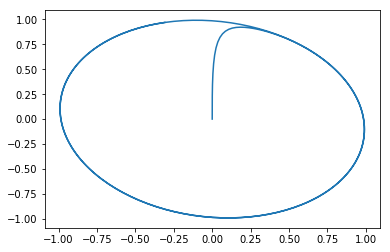

In [17]:
x_traj = np.array(x_traj)
u_traj = np.array(u_traj)
x_preds = np.array(x_preds)
plt.plot(x_traj[:,0], x_traj[:,1])

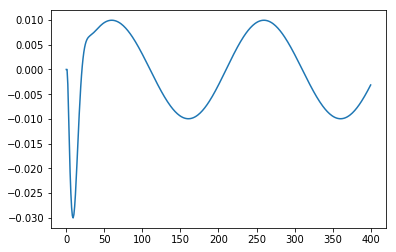

In [18]:
plt.plot(x_traj[:,2])